# Rapid Response Classification


## Download data with given Geojson file

In this case, we use Sentinel-2 data as input. We can download data with Sentinelsat API which can search for eligible data and download them. The conditions that can be selected here include data type, footfrint coverage, cloud coverage, time range and satellite orbit number, etc.

Firstly we need to sign up an account in Scihub and load a geojson file as footprint. Then we can search the eligible data and download them as zip files.

In [1]:
# import necessary packages
import numpy as np
import pandas as pd
import geopandas as gpd
import pyproj
import folium
from shapely import geometry
import matplotlib.pyplot as plt
import os, shutil
from glob import glob
import xml.dom.minidom
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt

In [ ]:
# setup API and login info
api =SentinelAPI('Sentinel2', 'Sentinel2Download!','https://scihub.copernicus.eu/apihub/')
footprint =geojson_to_wkt(read_geojson('./Downloads/map.geojson'))
# search data with some limits like range of date and cloud cover using given footprint.
# 
products =api.query(footprint,date=('20200827','20200902'), platformname='Sentinel-2', producttype = 'S2MSI2A', cloudcoverpercentage=(0,30))
product_name = []
# download searched data to local
for product in products:
    product_info = api.get_product_odata(product)
    if 'RVP' in product_info['title']:
        print(product_info['title'])
        product_name.append(product_info['title'])
        api.download(product)

## Transform ZIP file as GeoTIFF file

Then we need to change the zip files as GeoTiff file which can be finished by "gdal_translate" quary. Here we can use "gdalinfo" to get the details and find out the save path of bands needed. 
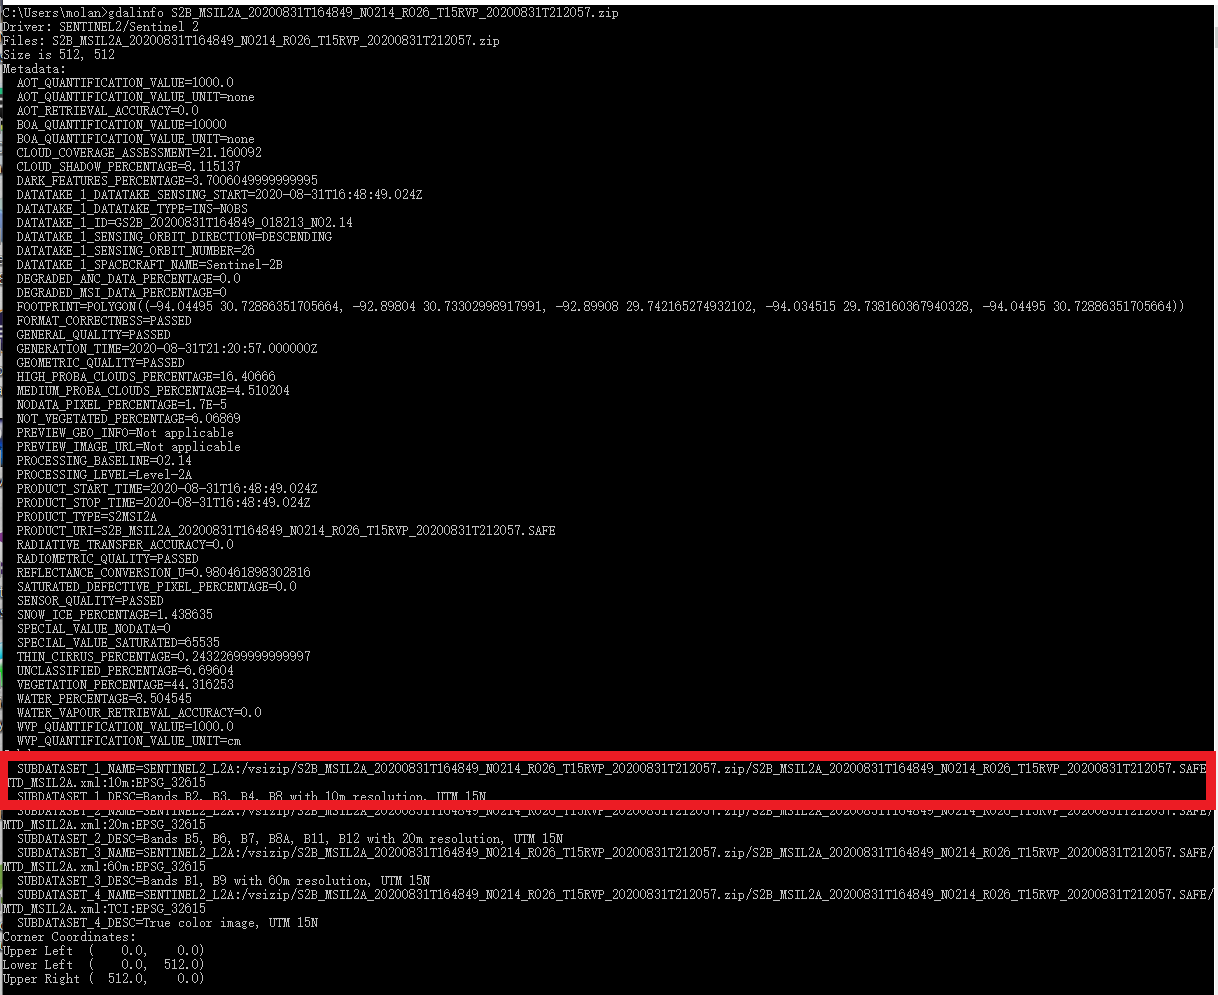

In this screenshot we can find the subdataset which saves highest resolution images and their geoprojection code(EPSG:32615). 

In [2]:
# import GeoTIFF package
import gdal
from PIL import Image
import matplotlib.image as mpimg
from osgeo import ogr
import subprocess
from collections import Counter
osgeo_home_bin = "C:\\OSGeo4W64\\bin"
os.environ['PATH'] = ''.join([osgeo_home_bin,";",os.environ['PATH']])http://localhost:8888/notebooks/S2_classification.ipynb#

In [ ]:
# use terminal quary to translate B2, B3, B4, and B8 as one multiple tif file.
for file_name in product_name: 
    quary = 'gdal_pansharpen.py -h'
    info = os.popen(quary)
    d = info.read()
    d = d.split('SUBDATASET_1_NAME=')
    d = d[1].split('\n')
    q = 'gdal_translate ' + d[0] + ' '+file_name+'.tif'
    info = os.popen(q)
    d = info.read()
    print(d)

## combine all GeoTIFF file and cut selected region 

After downloading data which overlap with the footprint, we need to combine them as one GeoTiff file. First, we can get each image's extent then find out the maximum and minimum of them as the extent of new combined file. Second, we need to create an empty GeoTiff file with the GeoTransform and projection from downloading data and calculate the array size by this extent. Last, we can write readen data in it one by one.

In [3]:
from gdalconst import *
import glob

In [4]:
def get_extent(fn):
    ds = gdal.Open(fn)
    rows = ds.RasterYSize
    cols = ds.RasterXSize
    gt = ds.GetGeoTransform()
    minx = gt[0]
    maxy = gt[3]
    maxx = gt[0] + gt[1] * rows
    miny = gt[3] + gt[5] * cols
    return (minx, maxy, maxx, miny)

In [ ]:
minX, maxY, maxX, minY = get_extent(product_name[0])
if len(product_name)> 1:
    for fn in product_name[1:]:
        minx, maxy, maxx, miny = get_extent(fn)
        minX = min(minX, minx)
        maxY = max(maxY, maxy)
        maxX = max(maxX, maxx)
        minY = min(minY, miny)
 
in_ds = gdal.Open(product_name[0])
gt = in_ds.GetGeoTransform()
rows = int(int(maxX - minX) / abs(gt[5]))
cols = int(int(maxY - minY) / gt[1])
 
print(rows,cols)
driver = gdal.GetDriverByName("GTiff")            
out_ds = driver.Create('union.tif', rows, cols, 4, gdal.GDT_Byte)
out_ds.SetProjection(in_ds.GetProjection())

gt = list(in_ds.GetGeoTransform())
gt[0], gt[3] = minX, maxY
out_ds.SetGeoTransform(gt)
 
for fn in product_name:
    in_ds = gdal.Open(fn)
    trans = gdal.Transformer(in_ds, out_ds, [])
    success, xyz = trans.TransformPoint(False, 0, 0)
    x, y, z = map(int, xyz)
    data = in_ds.GetRasterBand(1).ReadAsArray()
    for i in range(4):
    out_ds.GetRasterBand(i+1).WriteArray(data[i],x,y)
del in_ds, out_band, out_ds

In [2]:
date = '20200831'

When we get the unioned file, what we need to do is cutting the selected region from it. We can create a mask by given region and cut the overlapping area in the union file. But different file might use different coordinate reference system. Before creating the mask, we need to reproject the shape file with the coordinate reference system of Sentinel-2 data (EPSG:32615).

In [5]:
import rasterio as rio
import rasterio.mask
import json

In [118]:
src_path = date+'union.tif'
src = rio.open(src_path)


In [119]:
from geopandas import *
from geopandas import GeoSeries

shpdata = GeoDataFrame.from_file('./Downloads/layers/POLYGON.shp')
out_shpdata = shpdata.copy()
shpdata=shpdata.to_crs(src.crs)

features = shpdata.geometry[0].__geo_interface__
features

{'type': 'Polygon',
 'coordinates': (((458966.8393663813, 3324871.604189149),
   (498945.3833616929, 3324795.315654899),
   (498948.1554055458, 3353668.8751959438),
   (459074.697396889, 3353745.5604381296),
   (458966.8393663813, 3324871.604189149)),)}

In [124]:

out_image, out_transform = rio.mask.mask(src, [features], crop=True, nodata=src.nodata)
out_meta = src.meta.copy()
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
band_mask = rasterio.open(date+'cutted.tif', "w", **out_meta)
band_mask.write(out_image)

## Classify image

Our cutted GeoTiff file includes B2, B3, B4, and B8 band. At start, we need to generate NDVI (from (B8-B4/B8+B4)), and NDWI (from (B8-B3/B8+B3)) and add them as inout. 

In a word, we need to input a 6 bands image in our model. Here we can create a model by manually labeled pixels training data or just load the trained model. The model can reture a test result map which save each pixel's label (from 1 to 7). We can save it as a Tiff file, too.


In [11]:
#read the GeoTIFF file
def read_img(dataset): 
    im_width = dataset.RasterXSize    
    im_height = dataset.RasterYSize
    im_geotrans = dataset.GetGeoTransform() #affine matrix 
    im_proj = dataset.GetProjection() #Map projection information 
    im_bands = dataset.RasterCount
    im_data = dataset.ReadAsArray(0,0,im_width,im_height) 
    del dataset 
    return im_proj,im_geotrans,im_data

In [12]:
def write_img(filename,im_proj,im_geotrans,im_data):
        #type of data in gdal
        #gdal.GDT_Byte, 
        #gdal .GDT_UInt16, gdal.GDT_Int16, gdal.GDT_UInt32, gdal.GDT_Int32,
        #gdal.GDT_Float32, gdal.GDT_Float64
 
        if 'int8' in im_data.dtype.name:
            datatype = gdal.GDT_Byte
        elif 'int16' in im_data.dtype.name:
            datatype = gdal.GDT_UInt16
        else:
            datatype = gdal.GDT_Float32
 
        if len(im_data.shape) == 3:
            im_height, im_width, im_bands = im_data.shape
        else:
            im_bands, (im_width, im_height) = 1,im_data.shape 
 
        driver = gdal.GetDriverByName("GTiff")            
        dataset = driver.Create(filename, im_width, im_height, im_bands, datatype)
        dataset.SetGeoTransform(im_geotrans)              
        dataset.SetProjection(im_proj)                   
        if im_bands == 1:
            dataset.GetRasterBand(1).WriteArray(im_data)  
        else:
            for i in range(im_bands):
                dataset.GetRasterBand(i+1).WriteArray(im_data[i])
        print(im_data[i].shape)
        del dataset

In [13]:
def get_ndvi(data):  
    band8 = data[3]
    band4 = data[0]
    molecule = band8 - band4
    denominator = band8 + band4
    band = molecule / denominator
    band[band > 1] = -999
    band[band < -1] = -999
    return band

In [14]:
def get_ndwi(data):  
    band8 = data[3]
    band3 = data[1]
    molecule = band8 - band3
    denominator = band8 + band3
    band = molecule / denominator
    band[band > 1] = -999
    band[band < -1] = -999
    return band

In [15]:
# create MD model based on sample tiff file
def create_model():
    sample_path = 'E:/molan_research/flood/geo_tiff/S2A_MSIL1C_20200608T161911_N0209_R040_T16PBA_20200608T195512_MDClass.tif'
    sample_db = gdal.Open(sample_path)
    class_count = 6
    sp_proj,sp_geotrans,sp_data = read_img(sample_db)
    X=[[] for j in range(class_count)]
    for y in range(0, 10980):
        for x in range(0, 10980):
            i=0
            while i < class_count:
                if int(sp_data[0][y][x])==i:
                    X[i].append([y,x])
                i=i+1
    sample_im_path = 'E:/molan_research/flood/geo_tiff_pic/S2A_MSIL1C_20200608T161911_N0209_R040_T16PBA_20200608T195512.tif'
    sample_im_db = gdal.Open(sample_im_path)     
    sp_im_proj,sp_im_geotrans,sp_im_data = read_img(sample_im_db)
    ndvi = get_ndvi(sp_im_data)
    ndwi = get_ndwi(sp_im_data)
    sp_img_data = np.zeros((6,10980,10980))
    model_file = open('E:/molan_research/flood/MD_model.txt','w')
    for i in range(4) :
        temp = np.max(sp_im_data[i])
        sp_img_data[i,:,:] = sp_im_data[i]/temp
    sp_img_data[4,:,:] = ndvi
    sp_img_data[5,:,:] = ndwi
    input_data = sp_img_data
    model = []
    avg=np.zeros((class_count,6))
    for i in range(class_count):
        for j in range(len(X[i])):
            y=X[i][j][0]
            x=X[i][j][1]
            avg[i,:] = avg[i,:] + input_data[:,y,x]
        avg_sum=avg[i,:]/len(X[i])
        print(avg_sum)
        model.append(avg_sum)
        model_file.write(str(avg_sum)+'\n')
    model_file.close()
    return model

In [16]:
def load_model(path):
    model_file = open(path,'r')
    model = []
    for line in model_file:
        a = line.strip('\n').strip('[').strip(']').split(' ')
        print(a)
        model.append(list(map(float,line.strip('\n').strip('[').strip(']').split(' '))))
    print(model)
    return model

In [115]:
# detect 
def cal_box_new(model,data):  
    channel, height, width = data.shape
    ans_pic = []
    for k in range(len(model)):
        flag = model[k]
        flag_map = np.tile(flag,(height,width,1))
        flag_map = flag_map.transpose((2,0,1))
        differ = np.sqrt(sum(np.power((data - flag_map), 2)))
        ans_pic.append(differ)
    ans_pic = np.asarray(ans_pic)
    print(ans_pic.shape)
    ans=np.argmin(ans_pic,axis=0)
    return ans

In [101]:
def write_img(filename,im_proj,im_geotrans,im_data):
        #type of data in gdal
        #gdal.GDT_Byte, 
        #gdal .GDT_UInt16, gdal.GDT_Int16, gdal.GDT_UInt32, gdal.GDT_Int32,
        #gdal.GDT_Float32, gdal.GDT_Float64
 
        if 'int8' in im_data.dtype.name:
            datatype = gdal.GDT_Byte
        elif 'int16' in im_data.dtype.name:
            datatype = gdal.GDT_UInt16
        else:
            datatype = gdal.GDT_Float32
 
        if len(im_data.shape) == 3:
            im_bands, im_height, im_width = im_data.shape
        else:
            im_bands, (im_height, im_width) = 1,im_data.shape 
 
        driver = gdal.GetDriverByName("GTiff")            
        dataset = driver.Create(filename, im_width, im_height, im_bands, datatype)
        print(im_width, im_height)
        dataset.SetGeoTransform(im_geotrans)              
        dataset.SetProjection(im_proj)
        if im_bands == 1:
            dataset.GetRasterBand(1).WriteArray(im_data)  
        else:
            for i in range(im_bands):
                dataset.GetRasterBand(i+1).WriteArray(im_data[i])
                print(im_data[i].shape)
        del dataset

In [116]:
#model = create_model()
model = load_model('E:/molan_research/flood/MD_model.txt')

# calculate NDVI & MDWI band for each file
dataset=gdal.Open(date+'cutted.tif')
print(date+'cutted.tif')
im_proj,im_geotrans,im_data = read_img(dataset)
ndvi = get_ndvi(im_data)
ndwi = get_ndwi(im_data)
c,h,w = im_data.shape
print(h,w)
new_data = np.zeros((6,h,w))
for i in range(4) :
    temp = np.max(im_data[i])
    new_data[i,:,:] = im_data[i]/temp
new_data[4,:,:] = ndvi
new_data[5,:,:] = ndwi
input_pic = new_data

# detect and save result
ans = cal_box_new(model,input_pic)
print('finish: ')
save_path = 'E:/molan_research/flood/geo_tiff_test/'
write_img(date+'_class.tif',im_proj,im_geotrans,ans)

['0.06783793', '0.06662307', '0.04674708', '0.03642318', '-0.30561806', '-0.24246201']
['0.2162985', '0.23393789', '0.20558357', '0.2296819', '0.05326982', '0.0767491']
['0.10311744', '0.10844041', '0.08887721', '0.1361625', '0.14994955', '0.19150806']
['0.06916079', '0.0712208', '0.05539447', '0.10711419', '0.2295622', '0.27674547']
['0.04442409', '0.04864376', '0.02578345', '0.14835898', '0.54794165', '0.55587227']
['0.0548049', '0.05711809', '0.04077324', '0.1082272', '0.3436863', '0.37777808']
[[0.06783793, 0.06662307, 0.04674708, 0.03642318, -0.30561806, -0.24246201], [0.2162985, 0.23393789, 0.20558357, 0.2296819, 0.05326982, 0.0767491], [0.10311744, 0.10844041, 0.08887721, 0.1361625, 0.14994955, 0.19150806], [0.06916079, 0.0712208, 0.05539447, 0.10711419, 0.2295622, 0.27674547], [0.04442409, 0.04864376, 0.02578345, 0.14835898, 0.54794165, 0.55587227], [0.0548049, 0.05711809, 0.04077324, 0.1082272, 0.3436863, 0.37777808]]
20200831cutted.tif


D:\anaconda\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
D:\anaconda\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
D:\anaconda\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
D:\anaconda\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  


2896 3999
(6, 2896, 3999)
finish: 


## Show detected result in map 

We can display the test result in OpenStreet map or others by folium library. First I dye the result as given label. We can see only one spical label or overall result. 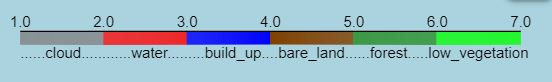

In [265]:
# create a colorful image to label each class
def write_label(im_data):
    water=[1.0,0,0,1]
    low_vegetation=[0,1.0,0,1]
    build_up=[0,0,1.0,1]
    bare_land = [128/255,64/255,0,1]
    cloud = [128/255,128/255,128/255,1]
    forest = [34/255,139/255,34/255,1]
    height,width = im_data.shape
    c,w,bu,bl,lv,f = np.zeros((height,width,4)),np.zeros((height,width,4)),np.zeros((height,width,4)),np.zeros((height,width,4)),np.zeros((height,width,4)),np.zeros((height,width,4))
    for i in range(height):
        for j in range(width):
            if im_data[i][j] == -1 or im_data[i][j] == 0:
                continue
            elif im_data[i][j] == 1 :
                w[i,j,:] = water
            elif im_data[i][j] == 2 :
                c[i,j,:] = cloud
            elif im_data[i][j] == 3 :
                bu[i,j,:] = build_up
            elif im_data[i][j] == 4 :
                bl[i,j,:] = bare_land
            elif im_data[i][j] == 5 :
                f[i,j,:] = forest
            elif im_data[i][j] == 6 :
                lv[i,j,:] = low_vegetation
    al = c+w+bu+bl+lv+f
    return al,c,w,bu,bl,lv,f


In [48]:
from osgeo import osr

In [201]:
import folium
import branca

In [135]:
ds = gdal.Open(date+'_class.tif')
nXSize = ds.RasterXSize 
nYSize = ds.RasterYSize 
gt = ds.GetGeoTransform()
im_data = ds.ReadAsArray(0,0,nXSize,nYSize)

In [266]:
al,c,w,bu,bl,lv,f = write_label(im_data)

In [154]:
# get the existing coordinate system
old_cs= osr.SpatialReference()
old_cs.ImportFromWkt(ds.GetProjectionRef())

# create the new coordinate system
wgs84_wkt = """
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.01745329251994328,
        AUTHORITY["EPSG","9122"]],
    AUTHORITY["EPSG","4326"]]"""
new_cs = osr.SpatialReference()
new_cs .ImportFromWkt(wgs84_wkt)

# create a transform object to convert between coordinate systems
transform = osr.CoordinateTransformation(old_cs,new_cs) 


In [155]:
min_lon = gt[0]
min_lat = gt[3]
max_lon = gt[0] + nXSize * gt[1] + nYSize * gt[2]
max_lat = gt[3] + nXSize * gt[4] + nYSize * gt[5]
min_latlong = transform.TransformPoint(min_lon,min_lat)
max_latlong = transform.TransformPoint(max_lon,max_lat)
lat_0 = (min_latlong[1]+max_latlong[1])/2
lon_0 = (min_latlong[0]+max_latlong[0])/2
bounds = [[min_latlong[1],min_latlong[0]],[max_latlong[1],max_latlong[0]]]

In [267]:
map_2 =folium.Map(location=[lat_0, lon_0], zoom_start=12)
img = folium.raster_layers.ImageOverlay(al, bounds,opacity = 1,name = date+" all classes")
img.add_to(map_2)
img = folium.raster_layers.ImageOverlay(c, bounds,opacity = 1,show = False, name = date+" cloud")
img.add_to(map_2)
img = folium.raster_layers.ImageOverlay(w, bounds,opacity = 1,show = False,name = date+" water")
img.add_to(map_2)
img = folium.raster_layers.ImageOverlay(bu, bounds,opacity = 1,show = False,name = date+" build_up area")
img.add_to(map_2)
img = folium.raster_layers.ImageOverlay(bl, bounds,opacity = 1,show = False,name = date+" bare land")
img.add_to(map_2)
img = folium.raster_layers.ImageOverlay(lv, bounds,opacity = 1,show = False,name = date+" low vegetation")
img.add_to(map_2)
img = folium.raster_layers.ImageOverlay(f, bounds,opacity = 1,show = False,name = date+" forest")
img.add_to(map_2)
folium.LayerControl().add_to(map_2)


In [268]:
water=(255,0,0)
low_vegetation=(0,255,0)
build_up=(0,0,255)
bare_land = (128,64,0)
cloud = (128,128,128)
forest = (34,139,34)
colors = [cloud,water,build_up,bare_land,forest,low_vegetation]
title = '......cloud............water.........build_up....bare_land......forest.....low_vegetation'
colormap = branca.colormap.StepColormap(colors,vmin=1.0,vmax=7.0,caption=title)

In [269]:
colormap.add_to(map_2)
map_2.save(date+'rapid_response.html')

In [272]:
map_2

## Open map as a website

In [3]:
import webbrowser
webbrowser.open(date+'rapid_response.html')

True